### Импорты

In [71]:
import pymorphy2
import string
import nltk
import numpy as np
import matplotlib.pyplot as plt
import itertools
import string
from stop_words import get_stop_words
from corus import load_wiki
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

### Загружаем список стоп-слов и пунктуационных знаков

In [72]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/adpashnin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adpashnin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Считываем дамп Вики, загруженный из https://github.com/natasha/corus

In [73]:
path = 'ruwiki-latest-pages-articles.xml.bz2'
records = load_wiki(path)

### Подготавливаем тексты из Вики для TF-IDF

In [74]:
wiki_texts = []
for i in range(100):
    wiki_texts.append(next(records).text)

### Токенизируем текст, вычищая стоп-слова и производя лемматизацию

In [75]:
def tokenize_ru(file_text):
    # firstly let's apply nltk tokenization
    tokens = word_tokenize(file_text)

    # let's delete punctuation symbols
    tokens = [i for i in tokens if (i not in string.punctuation)]

    # deleting stop_words
    stop_words = stopwords.words('russian') + get_stop_words('ru')
    stop_words.extend(['в', '', '•', '—', '–', 'к', 'на', '№', '©', '►','3–4','1–2','2–3', '5–7', '15–20', '10-15', '20–25', '...'])
    tokens = [i for i in tokens if ((i not in stop_words) and (len(i)>1) and (not i.isnumeric()))]
    # cleaning words
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]
    
    morph = pymorphy2.MorphAnalyzer()
    #stems=[]
    #for item in tokens:
    #   stems.append(SnowballStemmer("russian").stem(item))
    morphs = []
    for item in tokens:
        morphs.append(sorted(morph.parse(item), key=lambda p: p.score)[0].normal_form)
    
    return morphs

## TF IDF

In [76]:
def tf_idf(corpus, feature_count):
    corpus = [content]+wiki_texts
    stop_words = stopwords.words('russian') + get_stop_words('ru')
    vectorizer = TfidfVectorizer(tokenizer = tokenize_ru)
    X = vectorizer.fit_transform(corpus)
    features = np.array(vectorizer.get_feature_names())
    return features[(-X.toarray()[0]).argsort()[:feature_count]]

`features` - содержит термины из документа

In [77]:
features_count = 1000
# texts_count = 8
features_per_text = {}
# for i in range(texts_count):
#     print(f'parsing {i}.txt file')
with open('doc.txt', 'r') as file:
    content = file.read().replace('\n', ' ')
#     features_per_text[i] = tf_idf(content, features_count)
    features = tf_idf(content, features_count)

In [78]:
features

array(['нарезать', 'масло', 'перец', 'зелень', 'вымыть', 'соль',
       'петрушка', 'мл', 'выложить', 'ложка', 'приготовление',
       'ингредиент', 'сливочный', 'яйцо', 'добавить', 'минуть', 'укроп',
       'мука', 'очистить', 'лука', 'растительный', 'перемешать',
       'столовый', 'посолить', 'мелко', 'духовка', 'чеснок', 'ст',
       'посыпать', 'тесто', 'помидор', 'баклажан', 'смазать', 'сахара',
       'соус', 'способ', 'л.', 'смешать', 'сметана', 'сахар', 'разогреть',
       'молотый', 'ломтик', 'обжарить', 'измельчить', 'начинка',
       'луковица', 'мясо', 'лист', 'стол', 'взбить', 'стакан', 'морковь',
       'промыть', 'сок', 'залить', 'дрожжи', 'поперчить', 'вод', 'блюдо',
       'уксус', 'лимонный', 'тест', 'ч.', 'натереть', 'нарубить',
       'кусочек', 'пучок', 'майонез', 'килограмм', 'влить', 'филе',
       'готовый', 'противень', 'молока', 'приготовить', 'смесь',
       'пшеничный', 'кабачок', 'семя', 'бульон', 'репчатый', 'кусок',
       'картофель', 'кружочек', 'кубик

## Подсчёт вероятностей

#### Считываем весь документ

In [104]:
with open('doc.txt', 'r') as file:
         content = file.read().replace('\n', ' ')

#### Токенизируем текст

In [80]:
tokens = tokenize_ru(content)

#### Подсчитываем частоту

In [81]:
freq_dist = nltk.FreqDist(w.lower() for w in tokens)

#### Берём 1000 самых частых вхождений

In [82]:
freq_dist.most_common(1000)

[('масло', 5245),
 ('перец', 3662),
 ('соль', 3637),
 ('нарезать', 3599),
 ('зелень', 2904),
 ('добавить', 2566),
 ('приготовление', 2392),
 ('вымыть', 2362),
 ('л.', 2328),
 ('минуть', 2297),
 ('растительный', 2082),
 ('мука', 2064),
 ('способ', 2050),
 ('яйцо', 2046),
 ('петрушка', 2031),
 ('выложить', 2019),
 ('сливочный', 1955),
 ('мл', 1941),
 ('лука', 1923),
 ('очистить', 1902),
 ('вод', 1872),
 ('ст', 1828),
 ('ингредиент', 1799),
 ('ложка', 1748),
 ('длить', 1524),
 ('укроп', 1446),
 ('столовый', 1393),
 ('чеснок', 1292),
 ('перемешать', 1219),
 ('мясо', 1219),
 ('тесто', 1197),
 ('помидор', 1187),
 ('сахара', 1176),
 ('посолить', 1174),
 ('мелко', 1152),
 ('духовка', 1113),
 ('посыпать', 1100),
 ('баклажан', 1077),
 ('стол', 1058),
 ('лист', 1052),
 ('смазать', 1046),
 ('сахар', 1043),
 ('положить', 1014),
 ('поставить', 1013),
 ('молотый', 986),
 ('готовый', 979),
 ('соус', 977),
 ('течение', 944),
 ('разогреть', 924),
 ('сок', 907),
 ('килограмм', 876),
 ('смешать', 870),
 (

### Гистрограмма, просто интереса ради

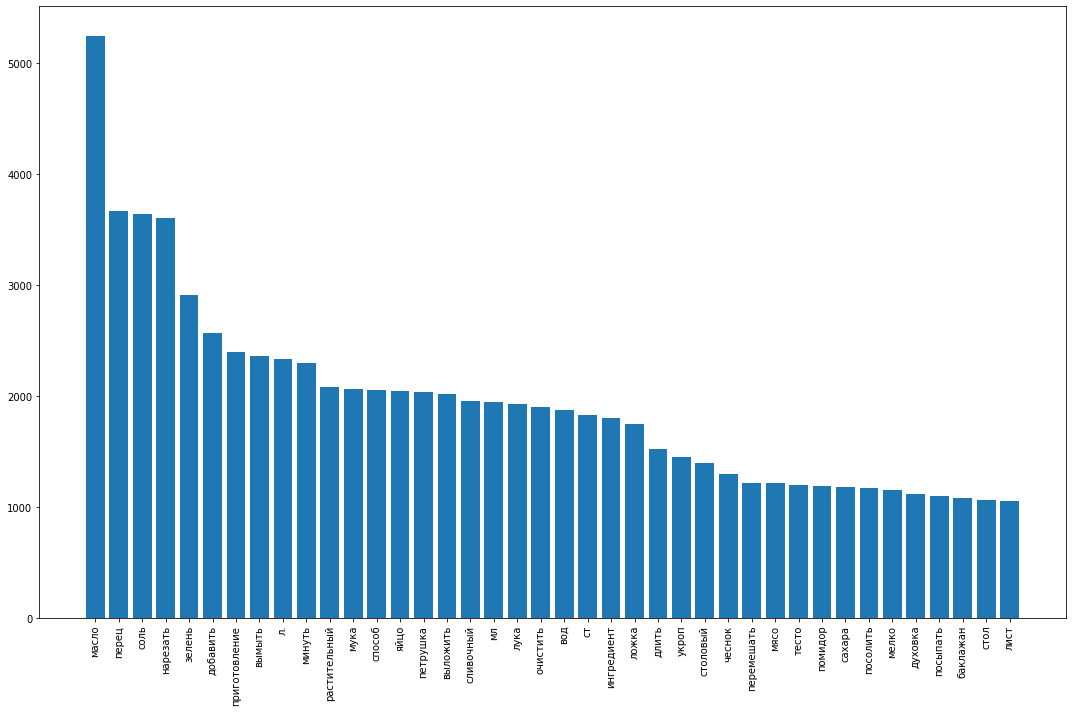

In [84]:
freq = freq_dist.most_common(40)

indices = np.arange(len(freq))
plt.figure(figsize=(15,10))
plt.bar(indices, list(map(lambda x: x[1], freq)))
plt.xticks(indices, list(map(lambda x: x[0], freq)), rotation='vertical')
plt.tight_layout()
plt.show()

## HAL Matrix

#### Считываем весь документ

In [85]:
with open('doc.txt', 'r') as file:
         content = file.read().replace('\n', ' ')

#### Токенизируем и преобразуем в сет

In [86]:
tokens = list(set(tokenize_ru(content)))

#### Берём окно, продвигаем его по всему тексту и для всех встреченных пар слов высчитываем расстояние

In [98]:
def hal_matrix(tokenized_text, all_tokens, frame_len=5):
    m_size =  len(all_tokens)
    hal = np.zeros([m_size, m_size])
    for t in range(len(tokenized_text)-frame_len):
        t_token = tokenized_text[t]
        for f_off in range(1, frame_len):
            off_token = tokenized_text[t+f_off]
            r = all_tokens.index(t_token)
            c = all_tokens.index(off_token)
            hal[r, c] += frame_len - f_off
            hal[c, r] += frame_len - f_off
                
    return hal

#### Строим 8 HAL матриц для каждой темы документа

In [96]:
texts_count = 8
hal_matrices = dict()
for i in range(texts_count):
    print(f'parsing {i}.txt file')
    with open(f'{i}.txt', 'r') as file:
        content = file.read().replace('\n', ' ')
    tokenized_text = tokenize_ru(content)
    hal_matrices[i] = hal_matrix(tokenized_text, tokens, 5)

parsing 0.txt file
parsing 1.txt file
parsing 2.txt file
parsing 3.txt file
parsing 4.txt file
parsing 5.txt file
parsing 6.txt file
parsing 7.txt file


In [119]:
np.unravel_index(hal_matrices[7].argmax(), hal_matrices[7].shape)

(3006, 5874)

In [120]:
tokens[3006] + ' '+ tokens[5874]

'перец молотый'